In [114]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
import os
working_dir = os.path.expanduser('~/workspace/theislab/mubind/docs/notebooks/scatac')
if os.path.exists(working_dir):
    os.chdir(working_dir)

In [116]:
pwd

'/mnt/c/Users/ibarr/Dropbox/workspace/theislab/mubind/docs/notebooks/scatac'

In [117]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cpu


In [118]:
atac_path = '../../../annotations/scatac/pancreas_multiome_2022_processed_sample_10000.h5ad'
os.path.exists(atac_path)

True

In [154]:
import scanpy as sc
adata = sc.read_h5ad(atac_path)

In [155]:
adata

AnnData object with n_obs × n_vars = 10000 × 10000
    obs: 'n_counts', 'sample', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'S_score', 'G2M_score', 'phase', 'proliferation', 'celltype', 'nCount_peaks', 'nFeature_peaks'
    var: 'modality'
    uns: 'celltype_colors', 'neighbors'
    obsm: 'X_pca', 'X_pca_wsnn', 'X_spca_wsnn', 'X_umap', 'X_umap_ATAC', 'X_umap_GEX', 'X_umap_wsnn', 'lsi_full', 'lsi_red', 'umap', 'umap_ATAC', 'umap_GEX'
    obsp: 'connectivities', 'connectivities_wnn', 'distances', 'distances_wnn'

In [156]:
n_sample_cells = 100
n_sample_peaks = 3

In [157]:
adata.shape

(10000, 10000)

In [158]:
np.random.seed(100)

adata = adata[:,adata.var.modality == 'ATAC'].copy()
obs_sample = pd.Series(adata.obs_names).sample(n_sample_cells)
var_sample = pd.Series(adata.var_names).sample(n_sample_peaks)

adata = adata[adata.obs_names.isin(obs_sample),adata.var_names.isin(var_sample)]

In [159]:
adata.shape

(100, 3)

In [160]:
adata

View of AnnData object with n_obs × n_vars = 100 × 3
    obs: 'n_counts', 'sample', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'S_score', 'G2M_score', 'phase', 'proliferation', 'celltype', 'nCount_peaks', 'nFeature_peaks'
    var: 'modality'
    uns: 'celltype_colors', 'neighbors'
    obsm: 'X_pca', 'X_pca_wsnn', 'X_spca_wsnn', 'X_umap', 'X_umap_ATAC', 'X_umap_GEX', 'X_umap_wsnn', 'lsi_full', 'lsi_red', 'umap', 'umap_ATAC', 'umap_GEX'
    obsp: 'connectivities', 'connectivities_wnn', 'distances', 'distances_wnn'

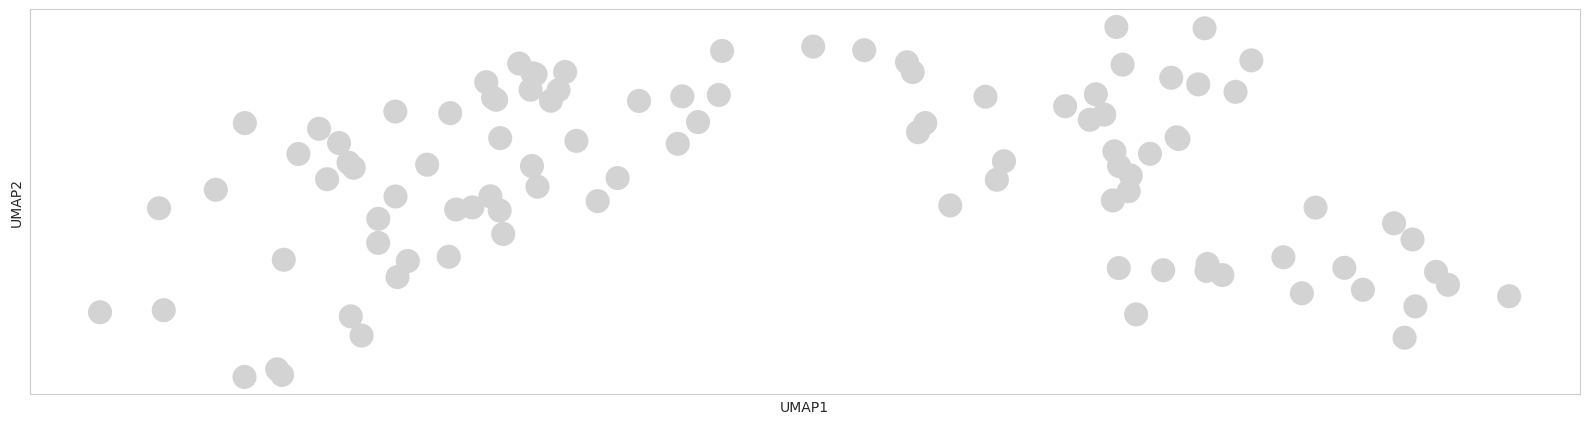

In [161]:
sc.pl.umap(adata)

In [162]:
adata.var

,modality
3-63786611-63787410,ATAC
10-67578442-67578949,ATAC
11-50114145-50115009,ATAC


In [163]:
adata.var['chr'] = 'chr' + adata.var_names.str.split('-').str[0]
adata.var['start'] = adata.var_names.str.split('-').str[1].astype(int)
adata.var['end'] = adata.var_names.str.split('-').str[2].astype(int)

In [164]:
extend = 50

adata.var['chr'].value_counts()

chr3     1
chr10    1
chr11    1
Name: chr, dtype: int64

In [165]:
adata.var['summit'] = ((adata.var['end'] + adata.var['start']) / 2).astype(int)
adata.var['summit.start'] = adata.var['summit'] - extend
adata.var['summit.end'] = adata.var['summit'] + extend

In [166]:
adata.var['k.summit'] = adata.var['chr'] + ':' + adata.var['summit.start'].astype(str) + '-' + adata.var['summit.end'].astype(str)

In [204]:
adata.shape

(100, 3)

In [168]:
n_seqs = 10000 # adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(adata.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='mm10', uppercase=True,
                                            gen_path='../../../annotations/mm10/genome/mm10.fa')
keys = set([s[0] for s in seqs])
adata = adata[:,adata.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]

convert bed to fasta
/tmp/tmp1c28zxk9
genome mm10 True
../../../annotations/mm10/genome/mm10.fa
True ../../../annotations/mm10/genome/mm10.fa
running bedtools...
bedtools getfasta -fi ../../../annotations/mm10/genome/mm10.fa -bed /tmp/tmp1c28zxk9 -fo /tmp/tmpqfc7mlow
get fasta
/tmp/tmpqfc7mlow


In [169]:
len(seqs)

3

In [170]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = adata.X.T

In [171]:
next_data = pd.DataFrame(counts.A) # sparse.from_spmatrix(counts.A)
# next_data = pd.DataFrame.sparse.from_spmatrix(counts)# var = []
# for ri, r in next_data.iterrows():
#     if ri % 1000 == 0:
#         print(ri, next_data.shape)
#     # print(ri, r.values[:-1], r.values[:-1].var())
#     var.append(r.values[:-1].var())
#     # break


next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()

next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'
next_data.shape

n_cells = 10000
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]

# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)

next_data_sel

del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']

df = next_data_sel.copy() # sample
# df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
# df.index = df.index.astype(str).str[35:-35]
# df = df[~df.index.duplicated(keep='first')]

zero_counts = df.sum(axis=1) == 0
df = df[~zero_counts] # remove zeroes

df.shape

(3, 100)

In [172]:
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index

In [173]:
df2 = df.reset_index().melt('seq').set_index('seq')
# add a baseline count
df2[0] = 1.0
cols = ['batch', 1, 0]
df2.columns = cols
df2 = df2[[0, 1, 'batch']] # cols[::-1]]
df2['batch'] = df2['batch'].astype(int)
print(df2.shape)
print(len(set(df2['batch'])))
n_cells = 200
df2 = df2[df2['batch'].isin(range(0, n_cells))]
print(df2['batch'].value_counts())
df2.head()

(300, 3)
100
0     3
63    3
73    3
72    3
71    3
     ..
30    3
29    3
28    3
27    3
99    3
Name: batch, Length: 100, dtype: int64


,0,1,batch
seq,,,
GAGGGCACCAGACTGAAGCTCGAGGTGCAGGTGGTTGTGACCCTCCATTCTCTTAGCTGCTGTGGCCTCTGTCAGTCGTCACAGTAGGATGGCTGTGTTC,1.0,0.0,0
GGACCACAAATTTAGGGCTGAGACCTGAGACAGGTCTCACTAGGGACAGGTTCCCCGTTCCCCTCAGCTTCTGTCTGTGATGTTGGAGTAAGTCTGTAAT,1.0,0.0,0
GTAGAGAGAGTGGTGTATCCATGGTGGGGAATGTTTCTAGCAAGCCAGGAATCAGCAGCTGGGACTCCTGCATTTTAATTCAGTTCACACATTGACCACT,1.0,0.0,0
GAGGGCACCAGACTGAAGCTCGAGGTGCAGGTGGTTGTGACCCTCCATTCTCTTAGCTGCTGTGGCCTCTGTCAGTCGTCACAGTAGGATGGCTGTGTTC,1.0,0.0,1
GGACCACAAATTTAGGGCTGAGACCTGAGACAGGTCTCACTAGGGACAGGTTCCCCGTTCCCCTCAGCTTCTGTCTGTGATGTTGGAGTAAGTCTGTAAT,1.0,0.0,1


### This is the relatedness graph and used for dynamics filters learning

In [174]:
# sum(adata.obs_names.isin(df.index)

In [175]:
len(seqs)

3

In [176]:
conn_sparse = adata[:,~zero_counts].uns['neighbors']['connectivities']
conn_sparse

<100x100 sparse matrix of type '<class 'numpy.float32'>'
	with 18 stored elements in Compressed Sparse Row format>

In [177]:
rel = conn_sparse.A
# rel[:n_cells,:n_cells].sum()
rel.shape

(100, 100)

In [178]:
# df2 = []
# for i in df.columns:
#     df3 = df[[i]].copy()
#     df3 = df3.head(100)
#     df3.columns = [0]
#     df3[1] = 1 # need a minimal non-zero count
#     df3['batch'] = i
#     df2.append(df3)
# df2 = pd.concat(df2)
# # df2['is_count_data'] = True
# dataset = mb.datasets.SelexDataset(df2, n_rounds=2, labels=[0, 1], enr_series=False)
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
len(set(dataset.batch))

1

In [179]:
n_batch = len(set(dataset.batch))
n_batch

1

In [180]:
# df = next_data_sel.copy()
# dataset = mb.datasets.GenomicsDataset(df)
# train = tdata.DataLoader(dataset=dataset, batch_size=1000, shuffle=True)

train = tdata.DataLoader(dataset=dataset, batch_size=1024, shuffle=True)


In [181]:
# log_etas = torch.tensor(np.log(df.sum(axis=0) / df.sum().sum())).reshape(1, n_batch).to(device)
# log_etas

In [182]:
b = np.random.randint(0, 2, (3, 4))
conn = np.random.randint(0, 2, (4, 4))

In [183]:
n_kernels = 5

In [184]:
import torch.optim as topti
import warnings
warnings.filterwarnings("ignore")

criterion = mb.tl.PoissonLoss()

w = [20 for i in range(n_kernels - 2)]
model = mb.models.Multibind.make_model(train, n_kernels, criterion, kernels=[0, 2] + w,
                                       # use_dinuc=True, dinuc_mode='full',
                                       optimize_sym_weight=False,
                                       optimize_exp_barrier=True,
                                       optimize_log_dynamic=False,
                                       use_dinuc=False,
                                       device=device,
                                       dinuc_mode=None)# .cuda()



In [185]:
model.prepare_knn(adata)

In [186]:
# %load_ext line_profiler

In [187]:
# %lprun -f model.selex_module.forward model.optimize_iterative(train, n_epochs=[500] + [200] * (n_kernels - 1), show_logo=False, use_mono=True, use_dinuc=False)

In [188]:
model, best_loss = model.optimize_iterative(train, n_epochs=[500] + [200] * (n_kernels - 1), show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                            opt_kernel_shift=[0, 0] + [0] * (n_kernels - 2),
                                            opt_kernel_length=[0, 0] + [0] * (n_kernels - 2),
                                            shift_max=1, shift_step=1, optimiser=topti.Adam,
                                            n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                            kernels = [0] + [2] + [20] * (n_kernels - 2), r2_per_epoch=True,
                                            exp_max=8,
                                            skip_kernels=range(3, 100),
                                            early_stopping=50, log_each=10, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

current kernels

Kernel to optimize 0

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
setting grad status of kernel (mono, dinuc) at 1 to (0, 0)
setting grad status of kernel (mono, dinuc) at 2 to (0, 0)
setting grad status of kernel (mono, dinuc) at 3 to (0, 0)
setting grad status of kernel (mono, dinuc) at 4 to (0, 0)
kernels mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 500 
early_stopping: 50
lr= 0.01, weight_decay= 0, dir weight= 0
Epoch: 11, Loss: 0.170081, R2: 0.06,  best epoch: 9,  secs per epoch: 0.018 s,  secs epoch*1k trials: 5.901s
Epoch: 21, Loss: 0.163240, R2: 0.10,  best epoch: 19,  secs per epoch: 0.028 s,  secs epoch*1k trials: 9.238s
Epoch: 31, Loss: 0.156663, R2: 0.13,  best epoch: 29,  secs per epoch: 0.029 s,  secs epoch*1k trials: 9.588s
Epoch: 41, Loss: 0.150397, R2: 0.17,  best epoch: 39,  secs per epoch: 0.028 s,  secs epoch*1k trials: 9.175s
Epoch: 51, Loss: 0.144484, R2: 0.21,  best epo

In [189]:
n_cols = len(model.binding_modes)

True
2


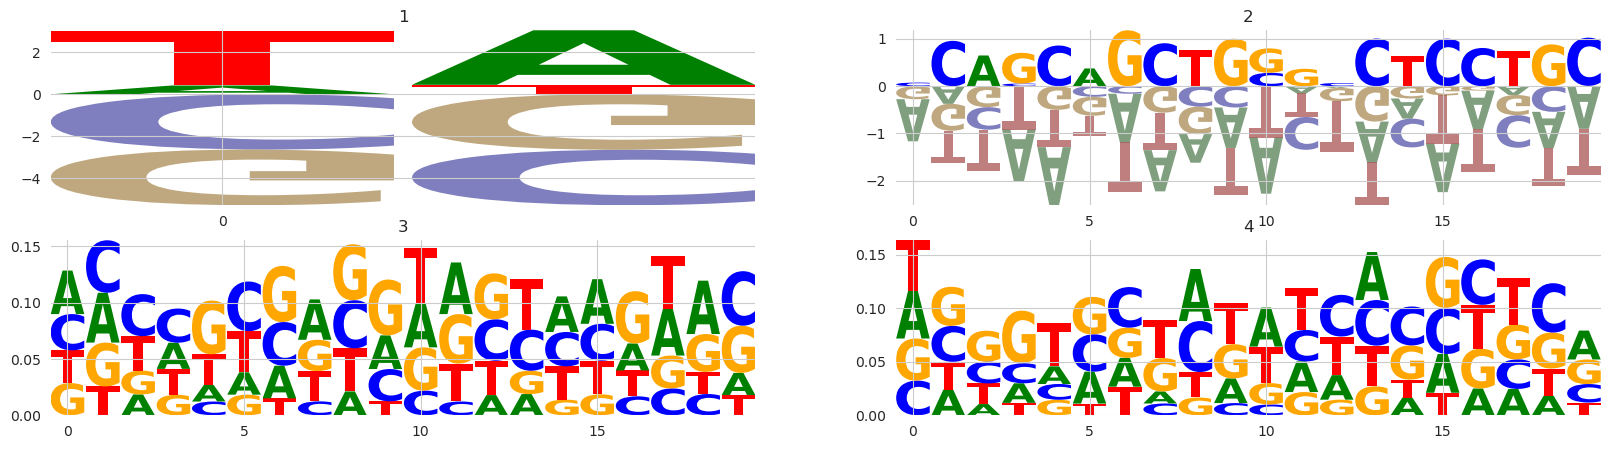

In [190]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 5
rcParams['figure.dpi'] = 100
mb.pl.conv(model, n_cols=int(n_cols / 2), n_rows=2, show=True)
plt.show()


In [191]:
# log_dynamic = model.selex_module.log_dynamic
# print(log_dynamic)
# log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)


In [192]:
tsum = torch.sum
texp = torch.exp
tspa = torch.sparse_coo_tensor
tsmm = torch.sparse.mm
t = torch.transpose

# connectivities
C = model.selex_module.conn_sparse
a_ind = C.indices()

log_dynamic = model.selex_module.log_dynamic
D = model.selex_module.log_dynamic
D_tril = tspa(a_ind, D, C.shape)  # .requires_grad_(True).cuda()
D_triu = tspa(a_ind, -D, C.shape)  # .requires_grad_(True).cuda()
D = D_tril + t(D_triu, 0, 1)
# log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
# triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
D

tensor(indices=tensor([[ 2, 17, 18, 21, 28, 30, 34, 28, 47, 48, 57, 18,  2, 17,
                        48, 47, 21, 58, 60, 74, 75, 89, 90, 97, 97, 75, 74, 90,
                        89, 58, 60],
                       [30, 34, 28, 57, 18,  2, 17, 18, 48, 47, 21, 28, 30, 34,
                        47, 48, 57, 97, 97, 75, 74, 90, 89, 58, 60, 74, 75, 89,
                        90, 97, 97]]),
       values=tensor([ 5.7226e-01,  3.6104e-01,  4.2567e+00,  5.9724e-01,
                      -3.2856e+00, -9.9397e-04,  1.7486e-03, -4.2567e+00,
                       7.5294e-01,  7.5229e-01, -1.2517e-06,  3.2856e+00,
                      -5.7126e-01, -3.6279e-01, -7.5294e-01, -7.5229e-01,
                      -5.9724e-01,  1.5667e-01,  7.0811e-01,  3.3632e-01,
                       3.3630e-01, -2.7709e+00,  3.4507e+00, -1.5954e-01,
                      -8.1919e-02, -3.3632e-01, -3.3630e-01,  2.7709e+00,
                      -3.4507e+00,  2.8697e-03, -6.2619e-01]),
       size=(100, 100),

In [193]:
# triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
log_dynamic

Parameter containing:
tensor([ 5.7226e-01,  3.6104e-01,  4.2567e+00,  5.9724e-01, -3.2856e+00,
         5.7126e-01,  3.6279e-01,  7.5294e-01,  7.5229e-01,  5.9724e-01,
         1.5667e-01,  7.0811e-01,  3.3632e-01,  3.3630e-01, -2.7709e+00,
         3.4507e+00, -2.8697e-03,  6.2619e-01], requires_grad=True)

In [194]:
log_dynamic.max()

tensor(4.2567, grad_fn=<MaxBackward1>)

<AxesSubplot: >

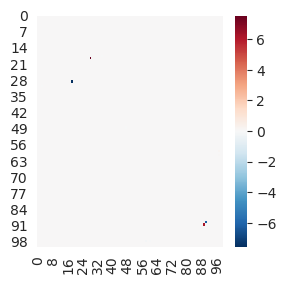

In [195]:
import seaborn as sns
mb.pl.set_rcParams({'figure.figsize': [3, 3]})
sns.heatmap(D.to_dense().detach().cpu(), cmap='RdBu_r')

<AxesSubplot: xlabel='index', ylabel='r2'>

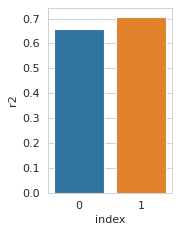

In [196]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 2, 3
rcParams['figure.dpi'] = 80
import seaborn as sns
r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
sns.barplot(data=r2, x='index', y='r2')

In [197]:
torch.set_printoptions(precision=2)
dynamic_score = D.to_dense().detach().cpu().sum(axis=0)


In [198]:

# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
adata.obs['dynamic_score'] = dynamic_score

Text(0.5, 7.555555555555548, 'dynamic score (normalized)')

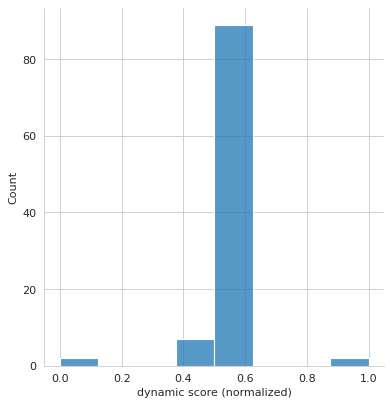

In [199]:
adata.obs['dynamic_score_cluster'] = np.where(dynamic_score > dynamic_score.mean(), 'dynamic', 'static')
z1 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 1, 'dynamic', 'static')
z2 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 2, 'dynamic', 'static')

adata.obs['dynamic_score_z1'] = z1
adata.obs['dynamic_score_z2'] = z2

#  ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > .5, , 0)
sns.displot(dynamic_score)
plt.xlabel('dynamic score (normalized)')


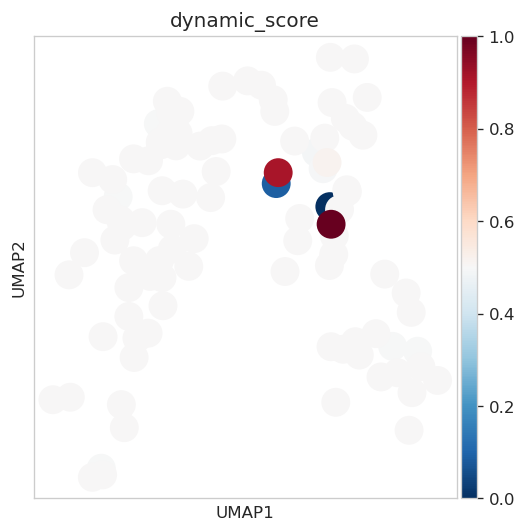

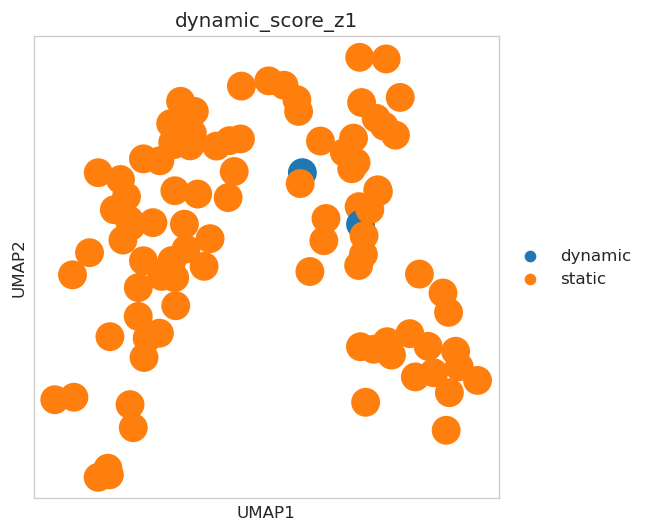

In [200]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 120
sc.pl.umap(adata, color=['dynamic_score'], cmap='RdBu_r', sort_order=True)
sc.pl.umap(adata, color=['dynamic_score_z1'], cmap='RdBu_r', sort_order=True)


In [201]:
# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
adata.obs['dynamic_score'] = dynamic_score

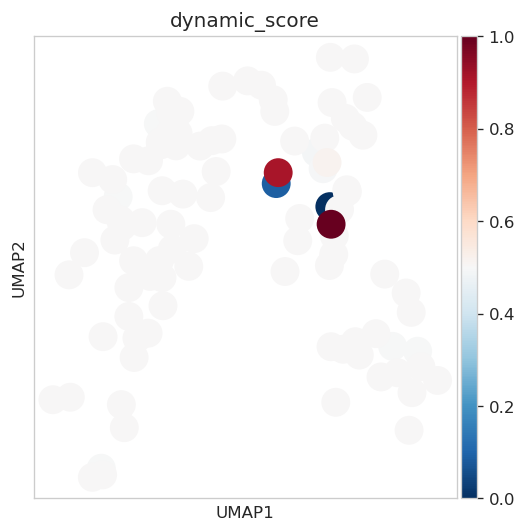

In [202]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 120
sc.pl.umap(adata, color='dynamic_score', cmap='RdBu_r', sort_order=True)


In [203]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 90
sc.tl.embedding_density(adata, basis='umap', groupby='dynamic_score_z1')
sc.pl.embedding_density(adata, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')
sc.tl.embedding_density(adata, basis='umap', groupby='dynamic_score_z2')
sc.pl.embedding_density(adata, basis='umap', key='umap_density_dynamic_score_z2', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')

LinAlgError: 2-th leading minor of the array is not positive definite

In [ ]:
mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=8)

In [ ]:
import resource
print('total GB used:', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)
